In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import tqdm

import article

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

#### helper functions

In [3]:
def convert_seg_error_rate_pct(df):
    df.avg_segment_error_rate = df.avg_segment_error_rate * 100
    return df

In [4]:
def add_species(df, species):
    df['species'] = species
    return df

In [5]:
def filter_cleanups(df, cleanups):
    return df[df.cleanup.isin(cleanups)]

In [6]:
def clean_df(df, species, cleanups):
    df = convert_seg_error_rate_pct(df)
    df = add_species(df, species)
    df = filter_cleanups(df, cleanups)
    return df

### Figure

not using `sns.set_` because the `plt.annotate` arrows don't show up

In [7]:
# sns.set_style("white")
# sns.set_context("paper")

Load source data, generate figure

In [8]:
PROJ_ROOT = pyprojroot.here()
RESULTS_ROOT = PROJ_ROOT / 'results'
BF_RESULTS_ROOT = RESULTS_ROOT / 'Bengalese_Finches' / 'learncurve'
CANARY_RESULTS_ROOT = RESULTS_ROOT / 'Canaries' / 'learncurve'
FIGS_ROOT  = PROJ_ROOT / 'doc' / 'article' / 'figures'

In [9]:
THIS_FIG_ROOT = fname = FIGS_ROOT / 'mainfig_postprocess_error_rates'
THIS_FIG_ROOT.mkdir(exist_ok=True)

In [10]:
CLEANUPS = (
    'none',
    'min_segment_dur_majority_vote'
)

In [11]:
bf_error_csv_path = BF_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
bf_curve_df = pd.read_csv(bf_error_csv_path)

bf_curve_df = clean_df(
    bf_curve_df,
    'Bengalese Finch',
    CLEANUPS
)

In [12]:
canary_error_csv_path = CANARY_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
canary_curve_df = pd.read_csv(canary_error_csv_path)

canary_curve_df = clean_df(
    canary_curve_df,
    'Canary',
    CLEANUPS
)

In [13]:
hyperparams_expt_csv_path = RESULTS_ROOT / 'hyperparams_expts' / 'source_data.csv'
hyperparams_expt_df = pd.read_csv(hyperparams_expt_csv_path)

In [14]:
hyperparams_expt_df = filter_cleanups(hyperparams_expt_df, 
                                      CLEANUPS)

In [15]:
SPECIES_PALETTE = {
    'Bengalese Finch': 'lawngreen',
    'Canary': 'magenta'
}

We tested three different methods of post-processing; but to make the figure readable we just want to compare no post-processing with the method that performed best

In [16]:
CLEANUP = 'min_segment_dur_majority_vote'  # the one we show

In [17]:
CLEANUP_DASHES = {
    'none': 'dashed',
    'min_segment_dur_majority_vote': 'solid',
}

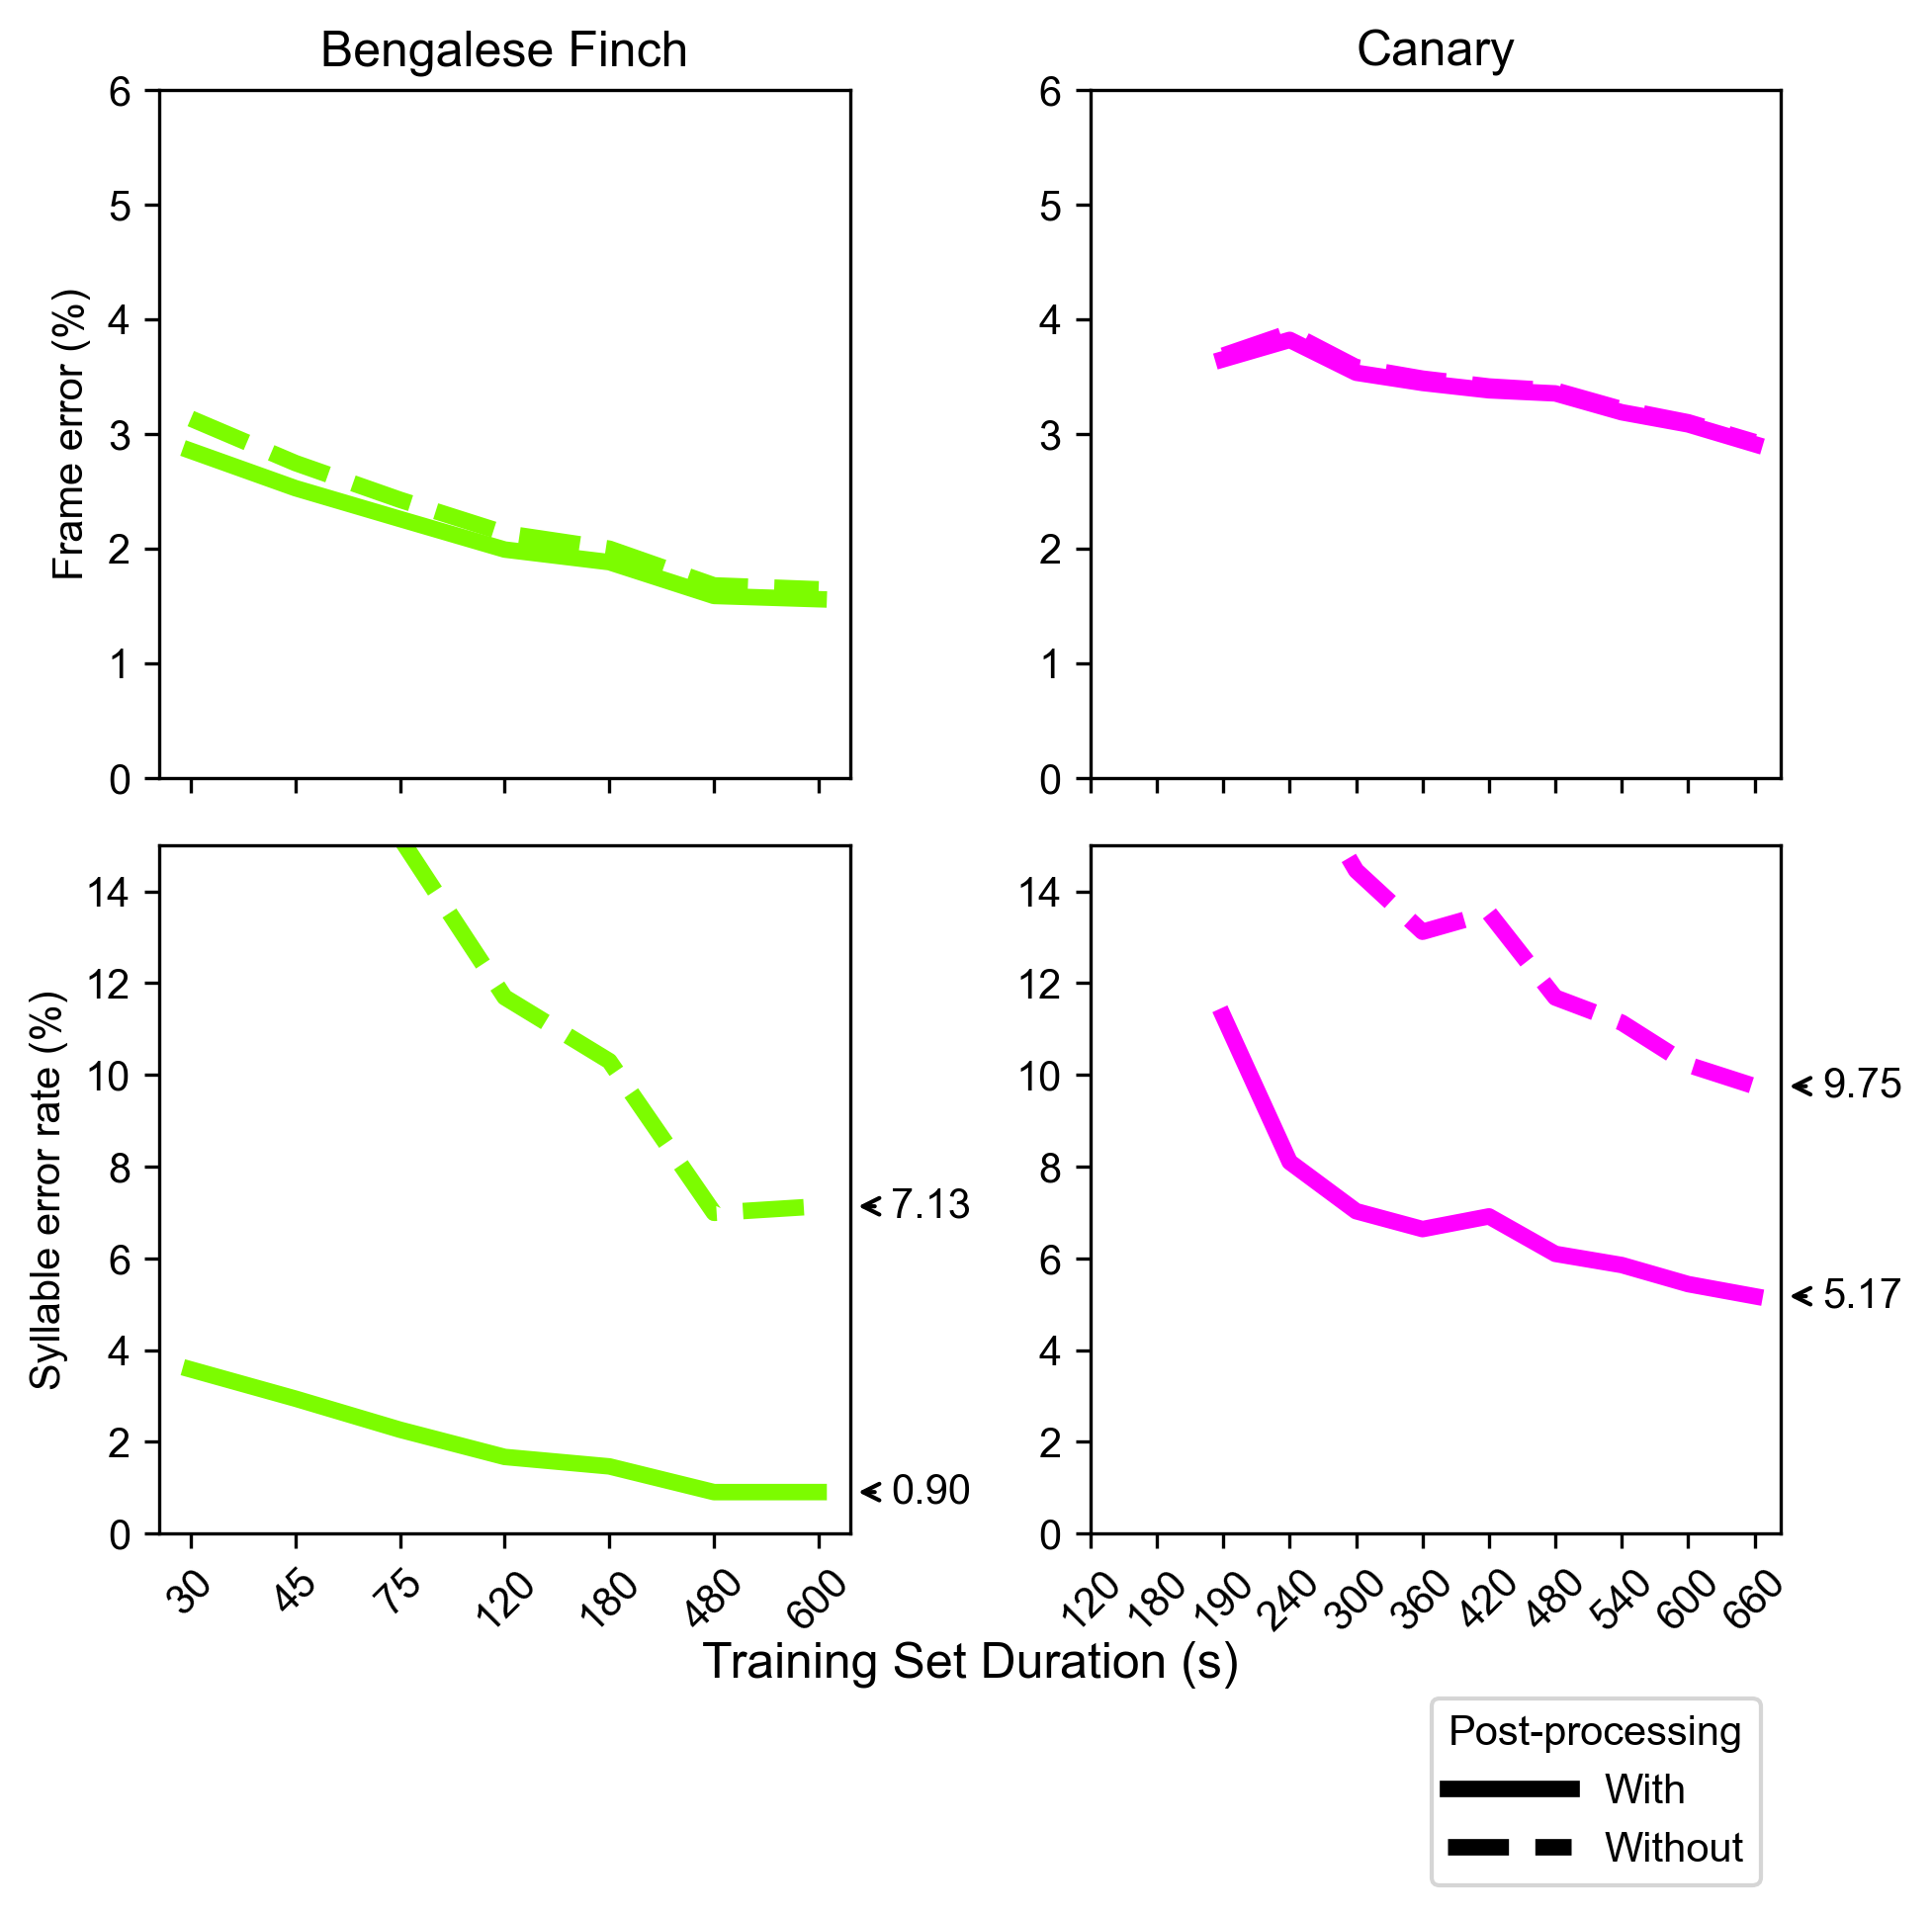

In [18]:
# make figure instance
FIGSIZE = (7, 7)
DPI = 300

NROWS = 2  # frame error rate, syllable error rate
NCOLS = 2  # Bengalese finches, Canaries

fig, ax_arr = plt.subplots(
    #constrained_layout=True,
    NROWS, NCOLS,
    figsize=FIGSIZE, 
    dpi=DPI
                )

metrics = [
    'avg_error',
    'avg_error',
    'avg_segment_error_rate',
    'avg_segment_error_rate',
]

cleanups = [
    'none',
    CLEANUP,
    'none',
    CLEANUP,
]

ylabels = [
    'Frame error (%)',
    'Frame error (%)',
    'Syllable error rate (%)',
    'Syllable error rate (%)',
]

species = [
    'Bengalese Finch',
    'Canary'
]

LEGEND = False

for col, (species_name, curve_df) in enumerate(
    zip(
        species,
        [bf_curve_df, canary_curve_df],
    )
):
    TRAIN_DUR_IND_MAP = {
        k:v for k, v in zip(
            sorted(curve_df['train_set_dur'].unique()), 
            sorted(curve_df['train_set_dur_ind'].unique())
        )
    }

    for metric, cleanup, ylabel in zip(metrics, cleanups, ylabels):
        if metric == 'avg_error':
            row = 0
        elif metric == 'avg_segment_error_rate':
            row = 1

        ax = ax_arr[row, col]

        curve_df_cleanup = curve_df[curve_df.cleanup == cleanup]

        if species_name == 'Canary':
            # only plot mean for training set durations where we have results for all birds, which is > 180
            curve_df_for_mean = curve_df_cleanup[curve_df_cleanup.train_set_dur > 180]
        else:
            curve_df_for_mean = curve_df_cleanup
        
        sns.lineplot(x='train_set_dur_ind',
                     y=metric, 
                     data=curve_df_for_mean,
                     ci=None,
                     color=SPECIES_PALETTE[species_name],
                     linestyle=CLEANUP_DASHES[cleanup],
                     linewidth=4, 
                     label='mean',
                     ax=ax,
                     legend=LEGEND)
        mean_acc_max_dur = curve_df_for_mean[
            curve_df_for_mean.train_set_dur == curve_df_for_mean.train_set_dur.max()
        ][metric].mean()

        if col == 0:
            ylabel_text = ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')

        xticks = list(TRAIN_DUR_IND_MAP.values())
        ax.set_xticks(xticks)
        if row == NROWS - 1:
           ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)
        else:
            ax.set_xticklabels([])

        if metric == 'avg_segment_error_rate':
            # only annotate for this metric, because for frame error it will overlap
            ax.annotate(f'{mean_acc_max_dur:0.2f}',
                        xy=(ax.get_xlim()[-1], mean_acc_max_dur), 
                        xycoords='data',
                        xytext=(10, 0), 
                        textcoords='offset points',
                        verticalalignment='center',
                        arrowprops=dict(arrowstyle="->", facecolor='black'),
                        annotation_clip=False)

            
        if row == 0:
            title_text = ax.set_title(species_name)  # use Text instance below for 'big panel axis'

# zoom-in / limit the view to different portions of the data
for ax in ax_arr[0, :]:
    ax.set_ylim(0, 6)
for ax in ax_arr[1, :]:
    ax.set_ylim(0, 15)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

# use Text instance from above so that this label is the same size as the axes titles
title_fontsize = title_text.get_size()
big_ax.set_xlabel("Training Set Duration (s)", labelpad=10, fontsize=title_fontsize);

from matplotlib.lines import Line2D
lines_for_legend = [
    Line2D([0], [0], color='k', lw=4, ls='solid'),
    Line2D([0], [0], color='k', lw=4, ls='dashed')
]
big_ax.legend(
    title='Post-processing',
    handles=lines_for_legend, 
    labels=['With', 'Without'],
    bbox_to_anchor=[0.75, -0.2, 0.25, 0.1],
    handlelength=3
)

fig.tight_layout()

for ext in ('svg', 'png'):
    fig.savefig(
        THIS_FIG_ROOT / f'mean-error-curves-with-without-post-process.{ext}',
        bbox_inches='tight',
    )

previous version of figure panel, in case we want it back

commented out so we can "restart and run all"

In [19]:
# FIGSIZE = (12, 6)
# DPI = 300

# fig = plt.figure(
#     #constrained_layout=True,
#     figsize=FIGSIZE, 
#     dpi=DPI
# )

# NROWS = 2  # window size, hidden size
# NCOLS = 4  # (Bengalese finches, Canaries) * (frame error, syllable error rate)
# gs = fig.add_gridspec(2, 4)
# ax_arr = []
# for i in range(NROWS):
#     for j in range(NCOLS):
#         ax = fig.add_subplot(gs[i, j])
#         ax_arr.append(ax)

# ax_arr = np.array(ax_arr).reshape(NROWS, NCOLS)

# SPECIES = (
#     'Bengalese Finch',
#     'Canary'
# )

# HYPERPARAM_EXPTS = {
#     'window_size': 'Window Size',
#     'hidden_size': 'Hidden state size',
# }

# METRICS = {
#     'avg_error': 'Frame error (%)',
#     'avg_segment_error_rate': 'Segment\nerror rate (%)'
# }

# YLIMS = {
#     'Bengalese Finch': {
#         'avg_error': (0., 6.),
#         'avg_segment_error_rate': (0., 15.),
#     },
#     'Canary': {
#         'avg_error': (0., 6.),
#         'avg_segment_error_rate': (0., 15.),        
#     },
# }

# row_1_ax = fig.add_subplot(gs[0, :], frameon=False)
# row_2_ax = fig.add_subplot(gs[1, :], frameon=False)
# big_row_axes = [row_1_ax, row_2_ax]
# for row_ax in big_row_axes:
#     # hide tick and tick label of the big axis
#     row_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     row_ax.grid(False)

# ylabel_fontsize = ylabel_text.get_size()  # get fontsize from Text instance, created above when making top panel
# # we use that below to set size for titles of smaller axes -- don't want them to be "title sized"

# for row, (row_ax, (hyperparam_expt, hyperparam_yaxis_label)) in enumerate(
#     zip(big_row_axes, HYPERPARAM_EXPTS.items())
# ):
#     # counter that starts over for each inner loop
#     col = 0

#     for species in SPECIES:
#         for metric_column_name, metric_axis_label in METRICS.items():
#             data = hyperparams_expt_df[
#                 (hyperparams_expt_df.species == species) &
#                 (hyperparams_expt_df.hyperparam_expt == hyperparam_expt)
#             ]

#             if species == 'Canary':
#                 # only plot mean for training set durations where we have results for all birds, which is > 180
#                 data = data[data.train_set_dur > 180]

#             ax = ax_arr[row, col]
            
#             palette = sns.dark_palette(
#                 SPECIES_PALETTE[species],
#                 as_cmap=True
#             )
            
#             for cleanup in CLEANUPS:
#                 if not col % 2 == 0 and cleanup == 'none':  # if column 1 or 3
#                     legend = True
#                 else:
#                     legend = False

#                 g = sns.lineplot(
#                     data=data[data.cleanup == cleanup],
#                     x='train_set_dur',
#                     y=metric_column_name,
#                     hue='hyperparam_val',
#                     palette=palette,
#                     ax=ax,
#                     linestyle=CLEANUP_DASHES[cleanup],
#                     legend=legend,
#                 )
#                 if legend:
#                     g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#             ax.set_ylim(YLIMS[species][metric_column_name])
#             ax.set_xlabel('')
#             ax.set_ylabel('')
#             plt.setp(ax.get_xticklabels(), **{'rotation': 45})

#             ax.tick_params(axis='both', which='major', pad=0.2)

#             if row == 0:
#                 ax.set_title(metric_axis_label, fontsize=ylabel_fontsize)  # set same size as y labels from top panel

#             if col == 0:
#                 row_ax.set_xlabel(hyperparam_yaxis_label, labelpad=9, fontsize=title_fontsize)

#             col +=1

# big_ax = fig.add_subplot(111, frameon=False)
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.grid(False)

# fig.tight_layout()

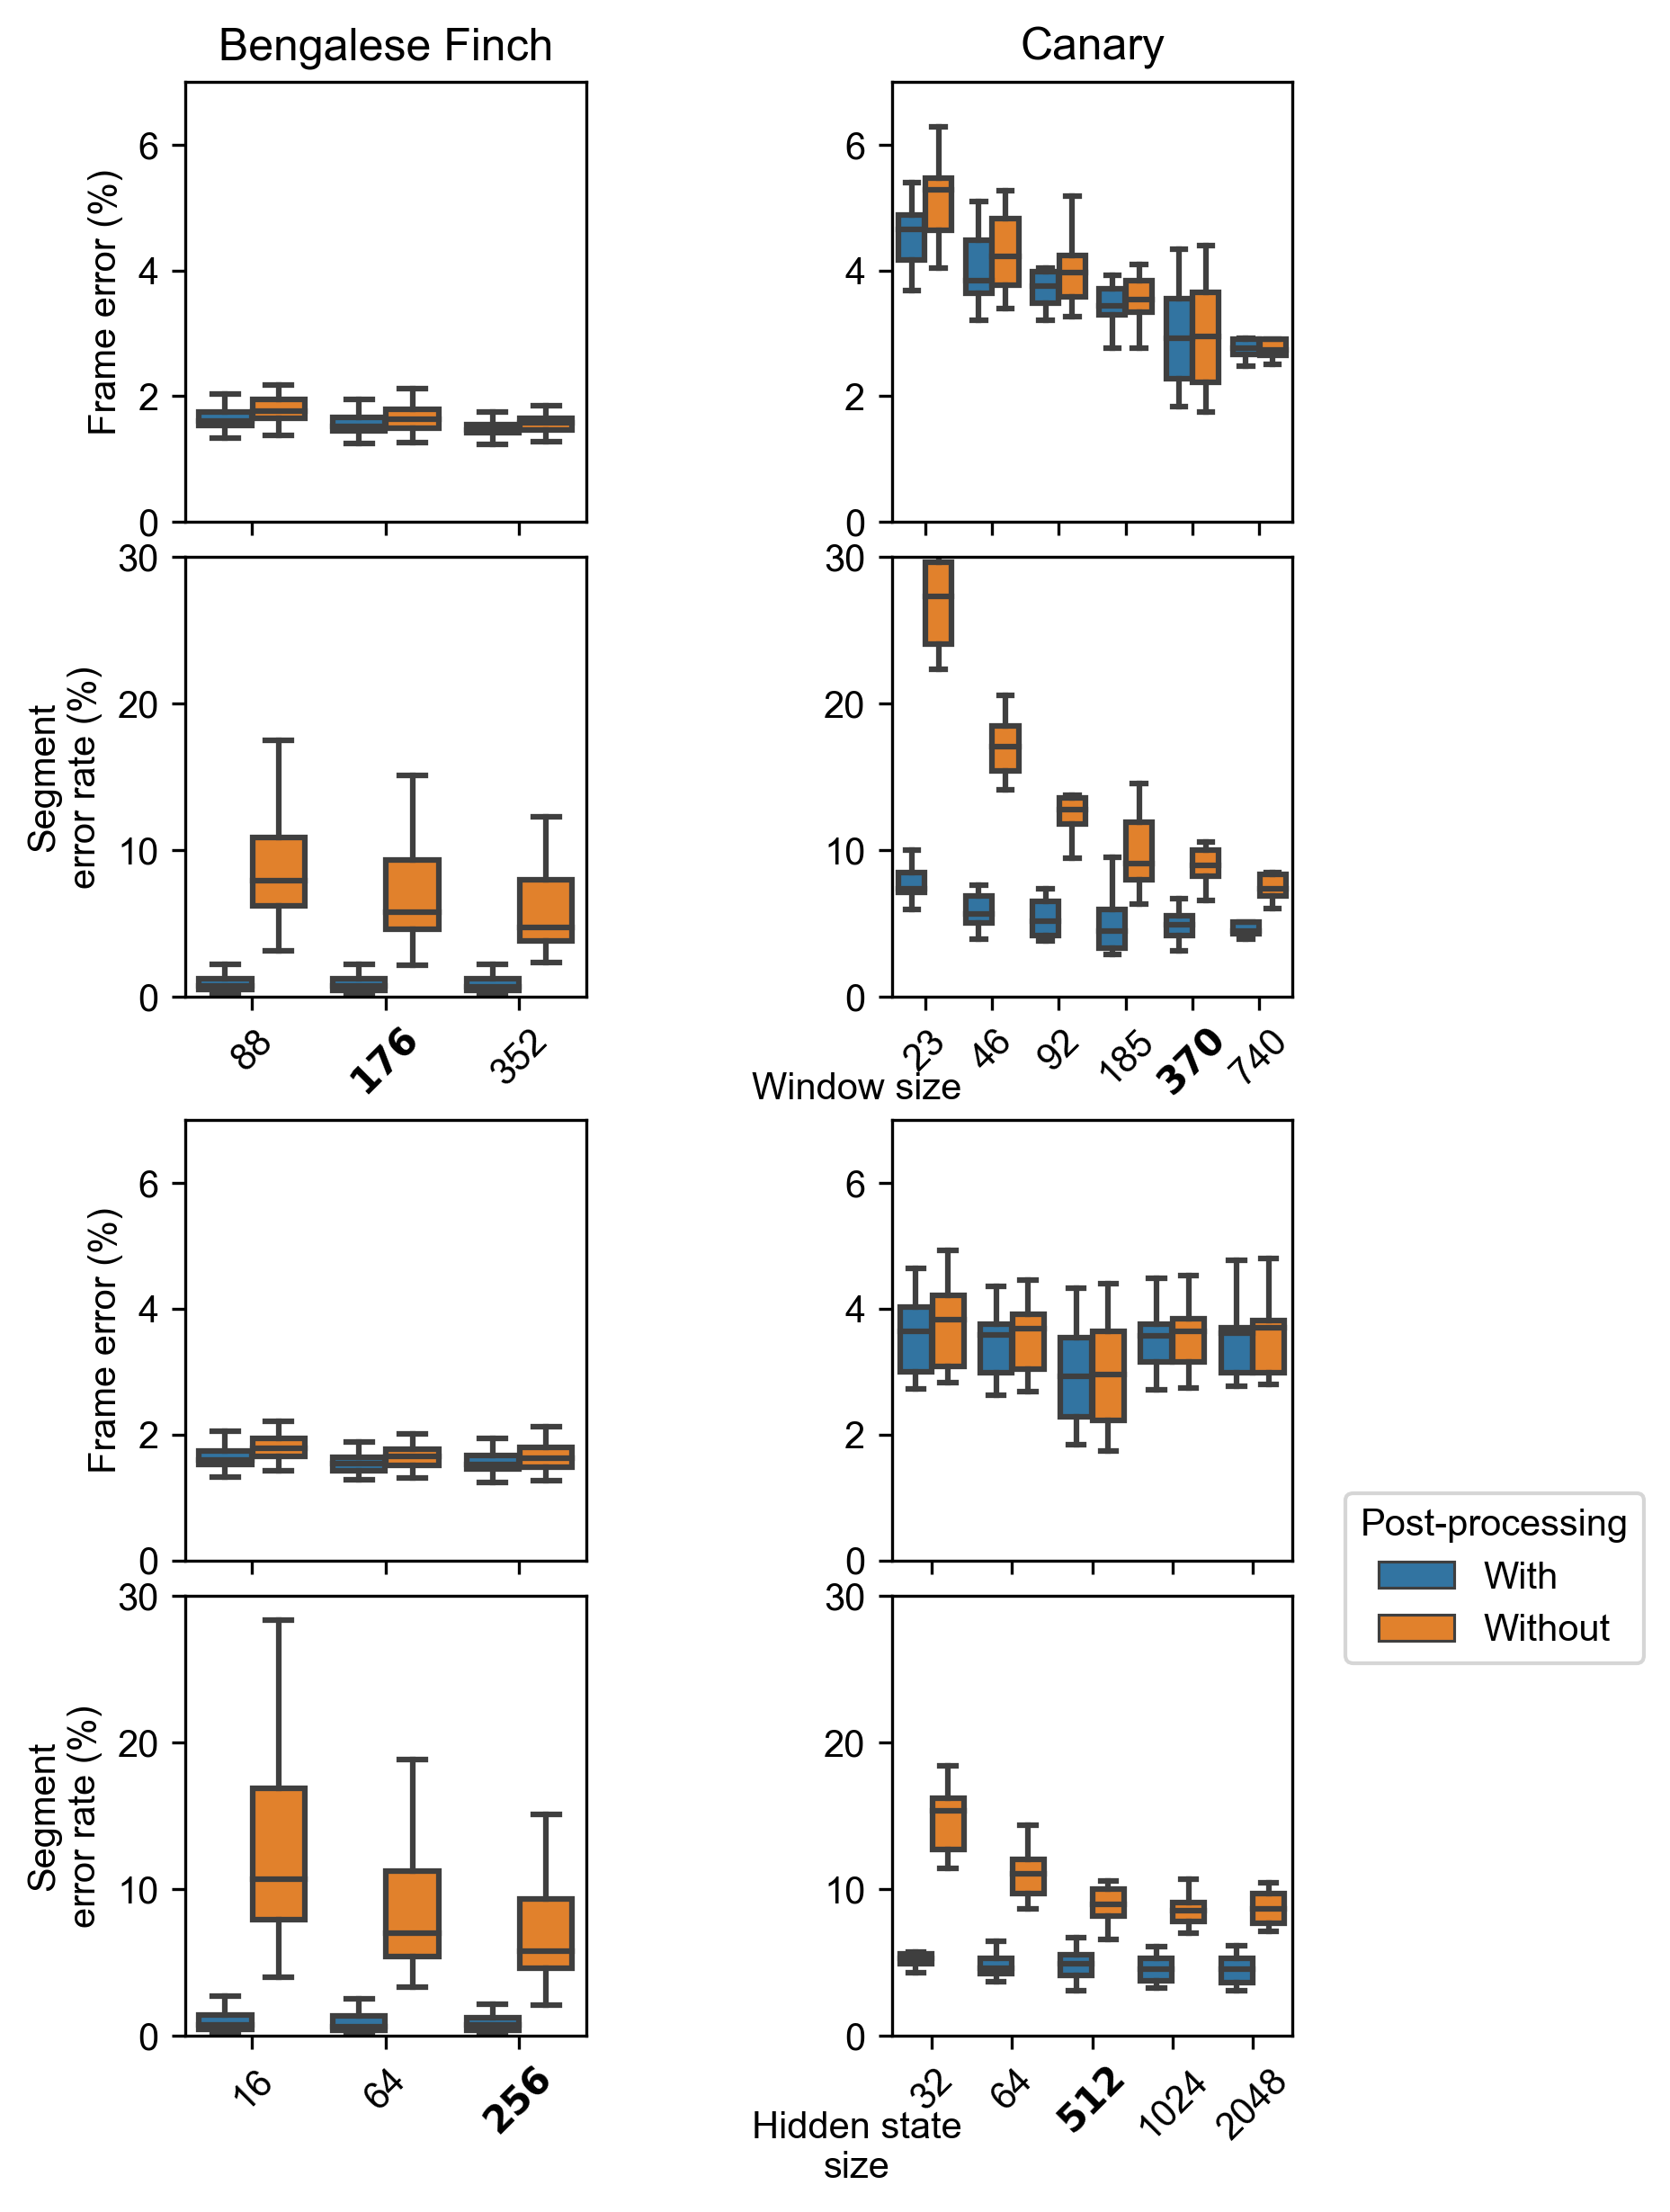

In [20]:
TRAIN_SET_DUR_TO_USE = {
    'Bengalese Finch': 600,
    'Canary': 660
}


FIGSIZE = (6, 8)
DPI = 300

fig = plt.figure(
    constrained_layout=True,
    figsize=FIGSIZE,
    dpi=DPI,
)

NROWS = 8
NCOLS = 6

fig.set_constrained_layout_pads(w_pad=0.05 / 72,
                                h_pad=0.05 / 72, 
                                hspace=0.,
                                wspace=0.)

gs = fig.add_gridspec(
    NROWS,
    NCOLS,
#     wspace=0.001,
#     hspace=0.001,
)

ROW_STARTSTOP = (
    (0, 2),
    (2, 4),
    (4, 6),
    (6, 8),
)

COL_STARTSTOP = (
    (0, 2),
    (3, 5)
)

ax_arr = []
for row_startstop in ROW_STARTSTOP:
    for col_startstop in COL_STARTSTOP:
        start_row, stop_row = row_startstop[0],  row_startstop[1]
        start_col, stop_col = col_startstop[0], col_startstop[1]
        ax = fig.add_subplot(gs[start_row: stop_row, start_col: stop_col])
        ax_arr.append(ax)

ax_arr = np.array(ax_arr).reshape(4, 2)

big_ax_arr = []  # used to add legends
BIG_AX_ROW_STARTSTOP = (
    (0, 4),
    (4, 8),
)
BIG_AX_COL_STARTSTOP = (
    (0, 3),
    (3, 6),
)

for row_startstop in BIG_AX_ROW_STARTSTOP:
    start_row, stop_row = row_startstop[0],  row_startstop[1]
    big_ax = fig.add_subplot(gs[start_row: stop_row, :], frameon=False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.grid(False)
    big_ax_arr.append(big_ax)
        
big_ax_arr = np.array(big_ax_arr)

SPECIES = (
    'Bengalese Finch',
    'Canary'
)

HYPERPARAM_EXPTS = {
    'window_size': 'Window size',
    'hidden_size': 'Hidden state\nsize',
}

# used to make these values bold in legend
HYERPARAM_FOR_FINAL_RESULTS = {
    'Bengalese Finch': {
        'hidden_size': 256,
        'window_size': 176,
    },
    'Canary': {
        'hidden_size': 512,
        'window_size': 370,
    }
}


METRICS = {
    'avg_error': 'Frame error (%)',
    'avg_segment_error_rate': 'Segment\nerror rate (%)'
}

YLIMS = {
    'Bengalese Finch': {
        'avg_error': (0., 7.),
        'avg_segment_error_rate': (0., 30.),
    },
    'Canary': {
        'avg_error': (0., 7.),
        'avg_segment_error_rate': (0., 30.),        
    },
}


for hyperparam_num, (hyperparam_expt, hyperparam_label) in enumerate(
    HYPERPARAM_EXPTS.items()
):
    big_ax = big_ax_arr[hyperparam_num]
    big_ax.set_xlabel(hyperparam_label)

    for col, species in enumerate(SPECIES):
        # use `metric_num` to compute row, `column_name` to get data from DataFrame, `label` as human-readable name for axes
        for metric_num, (metric_column_name, metric_label) in enumerate(METRICS.items()):
            data = hyperparams_expt_df[
                (hyperparams_expt_df.species == species) &
                (hyperparams_expt_df.hyperparam_expt == hyperparam_expt) & 
                (hyperparams_expt_df.train_set_dur == TRAIN_SET_DUR_TO_USE[species])
            ]

            row = hyperparam_num * 2 + metric_num
            ax = ax_arr[row, col]

            if row == 0:
                ax.set_title(species)

            # make it so we only generate one legend
            if row == 3 and col == 1:
                legend = True
            else:
                legend = False

            g = sns.boxplot(
                data=data,
                x='hyperparam_val',
                y=metric_column_name,
                showfliers=False,
                hue='cleanup',
                ax=ax,
            )
            if legend:
                handles, labels = ax.get_legend_handles_labels()
                g.legend_.remove()
                big_ax.legend(
                    title='Post-processing',
                    handles=handles,
                    labels=['With', 'Without'],
                    loc='center right', 
                    bbox_to_anchor=(1.1, 0.5)
                )
            else:
                g.legend_.remove()

            ax.set_ylim(YLIMS[species][metric_column_name])
            
            ax.set_xlabel('')
            if row == 1 or row == 3:
                new_xticklabels = []
                for xticklabel in ax.get_xticklabels():
                    if int(xticklabel.get_text()) == HYERPARAM_FOR_FINAL_RESULTS[species][hyperparam_expt]:
                        # make bold using latex
                        new_xticklabels.append(
                            fr'$\bf{{{xticklabel.get_text()}}}$'
                        )
                    else:
                        new_xticklabels.append(xticklabel.get_text())
                ax.set_xticklabels(new_xticklabels, rotation=45)                          

            else:
                ax.set_xticklabels([])

            if col == 0:
                ylabel_text = ax.set_ylabel(metric_label)  # we use `ylabel_tex` below, to get its fontsize
            else:
                ax.set_ylabel('')

# add a big axis, hide frame
# bigger_ax = fig.add_subplot(gs[7, :6], frameon=False)
# # # # hide tick and tick label of the big axis
# bigger_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# bigger_ax.grid(False)
# ylabel_fontsize = ylabel_text.get_size()
# bigger_ax.set_xlabel(
#     "Training Set Duration (s)", 
#     fontsize=title_fontsize);

for ext in ('svg', 'png'):
    fig.savefig(
        THIS_FIG_ROOT / f'hyperparams-expts.{ext}',
        bbox_inches='tight',
    )